In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import re
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (14, 6)

# load npy file to pandas dataframe
data = np.load("../data/processed/surat_cleaned.npy", allow_pickle=True)
df = pd.DataFrame(data)

# 4. Question Formulation

## 4.1 Research Question 1: Unit Price Efficiency Analysis
**The Question**

How does the relationship between property size (`square_feet`) and unit price (`price_per_sqft`) vary across different BHK configurations (1, 2, 3, 4+) and area types (Super Area vs. Carpet Area)?

Specifically: Does a specific **"area threshold"** exist where increasing the square footage no longer results in a competitive unit price (diminishing returns), and does this threshold differ between BHK groups?

**Motivation & Benefits**
* **Why this is worth investigating:** Real estate pricing is rarely linear. This analysis explores the "Core Pricing Logic," verifying whether larger properties offer economies of scale or if there is a point of diminishing returns.
* **Insights provided:** It identifies the "sweet spot" size for each apartment configuration (e.g., the optimal size for a 2BHK before it becomes overpriced relative to the market).
* **Stakeholders:**
    * **Home Buyers:** To identify "value-for-money" properties and avoid paying a premium for inefficiently large spaces.
    * **Investors:** To maximize rental yield potential by purchasing efficiently sized units.
    * **Real Estate Agents:** To justify pricing strategies to sellers based on market data.
* **Real-world decision:** This informs the decision of choosing a property that offers the best utility-to-price ratio.

# 5. Data analysis

## 5.1 Analysis for Question 1

#### A. Preprocessing
**Written Explanation:**
To ensure a fair comparison between size and price, we need to handle statistical noise and group sparse data.

**Workflow**

1.  Select relevant features (`square_feet`, `price_per_sqft`, `bhk`, `areaWithType`) needed for the research question.
2.  Create stable comparison groups (4+ BHK) to avoid tiny sample groups.
3.  Reduce the impact of extreme outliers using percentile trimming, keep values within the 1st–99th percentile for both `square_feet` and `price_per_sqft`.
4.  Keep only sufficiently large groups to ensure reliable trend estimation. Keep only (`bhk_group`, `areaWithType`) combinations with enough listings.

In [3]:
needed_cols = ["square_feet", "price_per_sqft", "bhk", "areaWithType"]
df_q1 = df[needed_cols].copy()

# ---------- Create a stable bhk grouping ----------
df_q1["bhk"] = df_q1["bhk"].astype(int)
df_q1["bhk_group"] = df_q1["bhk"].clip(upper=4).astype(int).astype(str)
df_q1.loc[df_q1["bhk"] >= 4, "bhk_group"] = "4+"

# ---------- Trim outliers by percentiles ----------
def keep_percentile_range(s: pd.Series, low: float, high: float) -> pd.Series:
    lo = s.quantile(low)
    hi = s.quantile(high)
    return s.between(lo, hi)

P_LOW, P_HIGH = 0.01, 0.99
mask_sqft = keep_percentile_range(df_q1["square_feet"], P_LOW, P_HIGH)
mask_ppsq = keep_percentile_range(df_q1["price_per_sqft"], P_LOW, P_HIGH)

df_q1 = df_q1[mask_sqft & mask_ppsq].copy()

# ---------- Keep only sufficiently large groups ----------
MIN_LISTINGS_PER_GROUP = 80

group_sizes = (
    df_q1.groupby(["bhk_group", "areaWithType"])
    .size()
    .sort_values(ascending=False)
)

valid_groups = group_sizes[group_sizes >= MIN_LISTINGS_PER_GROUP].index
df_q1 = df_q1.set_index(["bhk_group", "areaWithType"]).loc[valid_groups].reset_index()

print("df_q1 shape:", df_q1.shape)
display(group_sizes.head(15))

df_q1 shape: (2842, 5)


bhk_group  areaWithType
3          Super Area      799
2          Super Area      564
4+         Super Area      443
3          Carpet Area     390
2          Carpet Area     316
4+         Carpet Area     193
1          Super Area      137
           Carpet Area      53
dtype: int64

#### B. Analysis
Our analytical approach focuses on visualizing the non-linear relationship between size and unit price.
* **Analytical approach**

1. Exploratory visualization

- Plot price_per_sqft vs square_feet (x-axis in log scale), colored by bhk_group.


2. Robust trend estimation via quantile binning

- Within each (bhk_group, areaWithType), bin square_feet using quantile-based bins (qcut).

- For each bin, compute:

    - n (count),

    - sqft_median,

    - ppsqft_median.

3. Breakpoint estimation

- Fit a two-segment (piecewise) linear model on the binned medians:

    - Segment 1: small-to-medium area regime

    - Segment 2: larger area regime

- Choose the breakpoint that minimizes SSE (Sum of Squared Errors).

- Use log(sqft_median) as the x-variable to stabilize scale differences.

* **Expected outputs**

- Statistics tables

    - bin_stats: n, sqft_median, ppsqft_median per bin.

    - breakpoints: estimated breakpoint (sqft), slope_pre, slope_post, SSE per group.

- Visualizations

    - Scatter plot of raw data (sampled) by bhk_group

    - Binned median trend lines for Super Area

    - Binned median trend lines for Carpet Area

    - Bar chart of estimated breakpoints by group

- Interpretation targets

    - Identify if slope_post < 0 (evidence of diminishing returns)

    - Compare breakpoint magnitudes across BHK and area types

A ranked table of adjusted locality premiums/discounts (%, 95% CI, p-value)

At least 2 plots, for example:

Raw distribution of price_per_sqft across major localities (box/violin)

Adjusted premiums/discounts with confidence intervals (bar plot with error bars)

Optional diagnostics: model fit metrics (R²/AIC), residual checks, predicted vs actual plot

In [4]:
# ---------- Create quantile bins of square_feet within each (bhk_group, areaWithType) ----------
BINS_PER_GROUP = 20

def add_sqft_bins(g: pd.DataFrame) -> pd.DataFrame:
    g = g.copy()
    g["sqft_bin"] = pd.qcut(
        g["square_feet"],
        q=BINS_PER_GROUP,
        duplicates="drop"
    )
    return g

df_binned = (
    df_q1.groupby(["bhk_group", "areaWithType"], group_keys=False)
    .apply(add_sqft_bins)
)

bin_stats = (
    df_binned.groupby(["bhk_group", "areaWithType", "sqft_bin"])
    .agg(
        n=("price_per_sqft", "size"),
        sqft_median=("square_feet", "median"),
        ppsqft_median=("price_per_sqft", "median"),
    )
    .reset_index()
    .sort_values(["bhk_group", "areaWithType", "sqft_median"])
)

display(bin_stats.head(20))

# ---------- Segmented regression (2 segments) on the binned medians ----------
def best_two_segment_fit(x: np.ndarray, y: np.ndarray, min_pts: int = 4):
    x = np.asarray(x, dtype=float)
    y = np.asarray(y, dtype=float)

    order = np.argsort(x)
    x = x[order]
    y = y[order]

    if len(x) < 2 * min_pts + 1:
        return None

    best = None
    candidates = range(min_pts, len(x) - min_pts)

    for k in candidates:
        # Fit 2 lines (left & right)
        a1, b1 = np.polyfit(x[:k], y[:k], deg=1)
        a2, b2 = np.polyfit(x[k:], y[k:], deg=1)

        y_hat_left = a1 * x[:k] + b1
        y_hat_right = a2 * x[k:] + b2
        y_hat = np.concatenate([y_hat_left, y_hat_right])

        sse = np.sum((y - y_hat) ** 2)

        if (best is None) or (sse < best["sse"]):
            best = {
                "k": k,
                "sse": sse,
                "a1": a1, "b1": b1,
                "a2": a2, "b2": b2,
            }

    if best is None:
        return None

    bp = x[best["k"]]
    return {
        "breakpoint_x": bp,
        "slope_pre": best["a1"],
        "slope_post": best["a2"],
        "sse": best["sse"],
        "n_bins": len(x),
    }

# Fit on log(square_feet) to stabilize scale
results = []
for (bhk_g, area_t), g in bin_stats.groupby(["bhk_group", "areaWithType"]):
    g = g.sort_values("sqft_median")
    x = np.log(g["sqft_median"].values)
    y = g["ppsqft_median"].values

    fit = best_two_segment_fit(x, y, min_pts=4)
    if fit is None:
        continue

    bp_sqft = float(np.exp(fit["breakpoint_x"]))
    results.append({
        "bhk_group": bhk_g,
        "areaWithType": area_t,
        "breakpoint_sqft": bp_sqft,
        "slope_pre": fit["slope_pre"],
        "slope_post": fit["slope_post"],
        "n_bins": fit["n_bins"],
        "sse": fit["sse"],
    })

breakpoints = pd.DataFrame(results).sort_values(["bhk_group", "areaWithType"])
display(breakpoints)

,bhk_group,areaWithType,sqft_bin,n,sqft_median,ppsqft_median
0,1,Super Area,"(399.999, 428.2]",7,400.0000,2750.0
1,1,Super Area,"(428.2, 450.0]",10,450.0000,3004.5
2,1,Super Area,"(450.0, 480.0]",5,480.0000,3087.0
3,1,Super Area,"(480.0, 500.0]",10,500.0000,3300.0
4,1,Super Area,"(500.0, 540.0]",3,504.0000,3571.0
5,1,Super Area,"(540.0, 562.0]",6,550.0000,2159.0
6,1,Super Area,"(562.0, 600.0]",9,580.0000,3000.0
7,1,Super Area,"(600.0, 623.2]",5,616.0000,3226.0
8,1,Super Area,"(623.2, 650.0]",15,650.0000,2769.0
9,1,Super Area,"(650.0, 675.0]",6,665.5000,2996.5


,bhk_group,areaWithType,breakpoint_sqft,slope_pre,slope_post,n_bins,sse
0,1,Super Area,550.0,2952.883160,569.594722,19,2.101150e+06
1,2,Carpet Area,800.0,4472.954234,-482.189802,20,1.749476e+06
2,2,Super Area,1205.0,244.662515,1656.141334,20,8.484192e+05
3,3,Carpet Area,1400.0,3355.954955,-1567.594070,20,1.932184e+06
4,3,Super Area,1651.0,-3188.798961,4255.431340,20,1.013498e+06
5,4+,Carpet Area,2127.0,2421.613382,115.735341,20,5.079505e+06
6,4+,Super Area,2862.5,-4845.069494,2771.974644,20,3.298841e+06


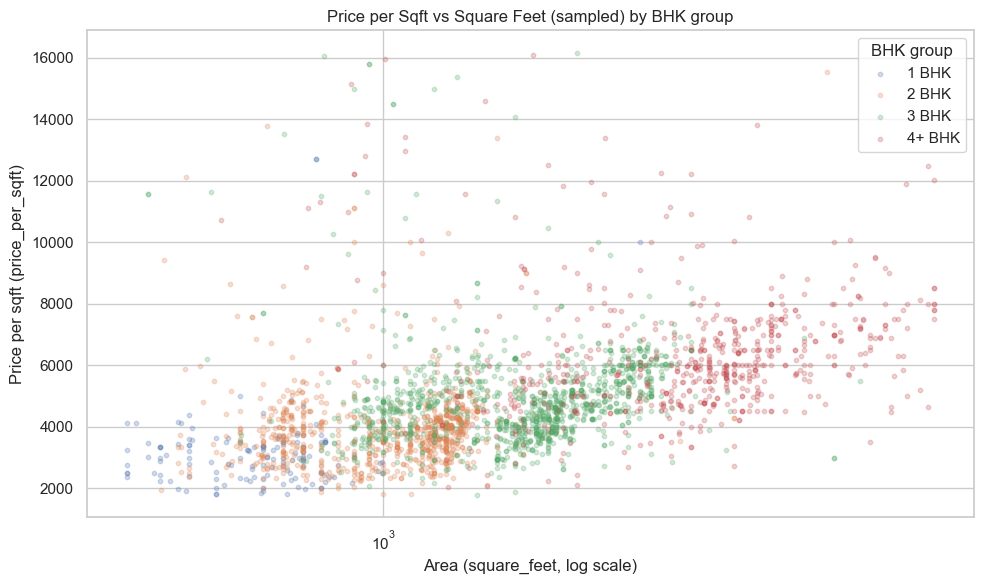

In [5]:
plt.figure(figsize=(10, 6))

sample_n = min(6000, len(df_q1))
df_plot = df_q1.sample(sample_n, random_state=42)

for bhk_g in sorted(df_plot["bhk_group"].unique()):
    g = df_plot[df_plot["bhk_group"] == bhk_g]
    plt.scatter(
        g["square_feet"],
        g["price_per_sqft"],
        s=10,
        alpha=0.25,
        label=f"{bhk_g} BHK"
    )

plt.xscale("log")
plt.title("Price per Sqft vs Square Feet (sampled) by BHK group")
plt.xlabel("Area (square_feet, log scale)")
plt.ylabel("Price per sqft (price_per_sqft)")
plt.legend(title="BHK group")
plt.tight_layout()
plt.show()

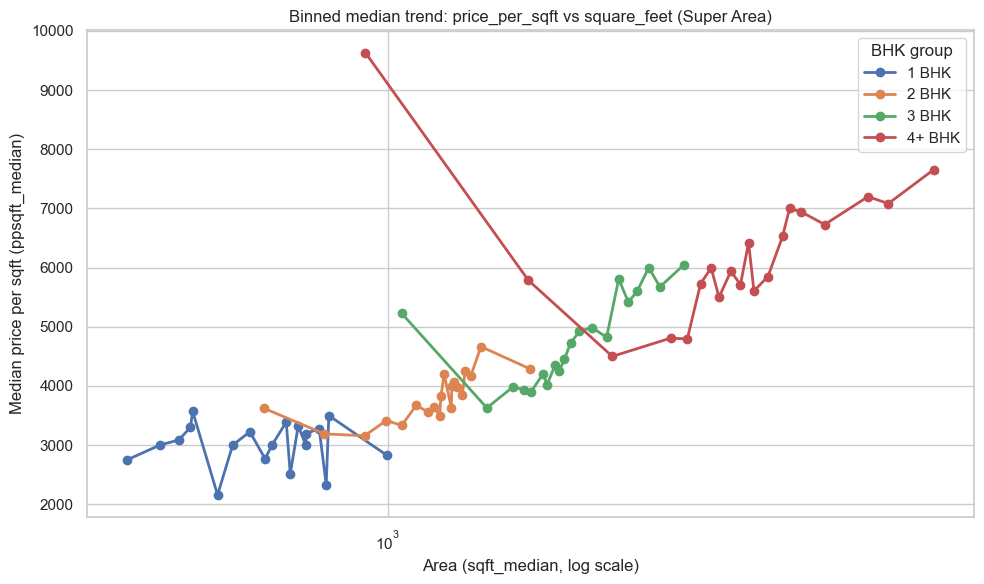

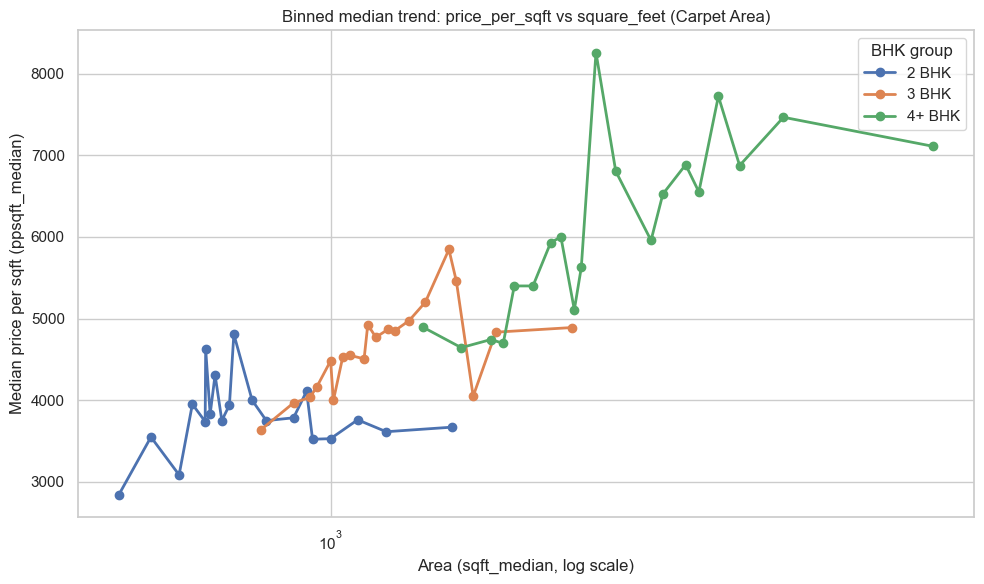

In [6]:
top_area_types = (
    df_q1["areaWithType"]
    .value_counts()
    .head(2)
    .index
    .tolist()
)

for area_t in top_area_types:
    plt.figure(figsize=(10, 6))
    sub = bin_stats[bin_stats["areaWithType"] == area_t].copy()

    for bhk_g in sorted(sub["bhk_group"].unique()):
        g = sub[sub["bhk_group"] == bhk_g].sort_values("sqft_median")
        plt.plot(
            g["sqft_median"],
            g["ppsqft_median"],
            marker="o",
            linewidth=2,
            label=f"{bhk_g} BHK"
        )

    plt.xscale("log")
    plt.title(f"Binned median trend: price_per_sqft vs square_feet ({area_t})")
    plt.xlabel("Area (sqft_median, log scale)")
    plt.ylabel("Median price per sqft (ppsqft_median)")
    plt.legend(title="BHK group")
    plt.tight_layout()
    plt.show()

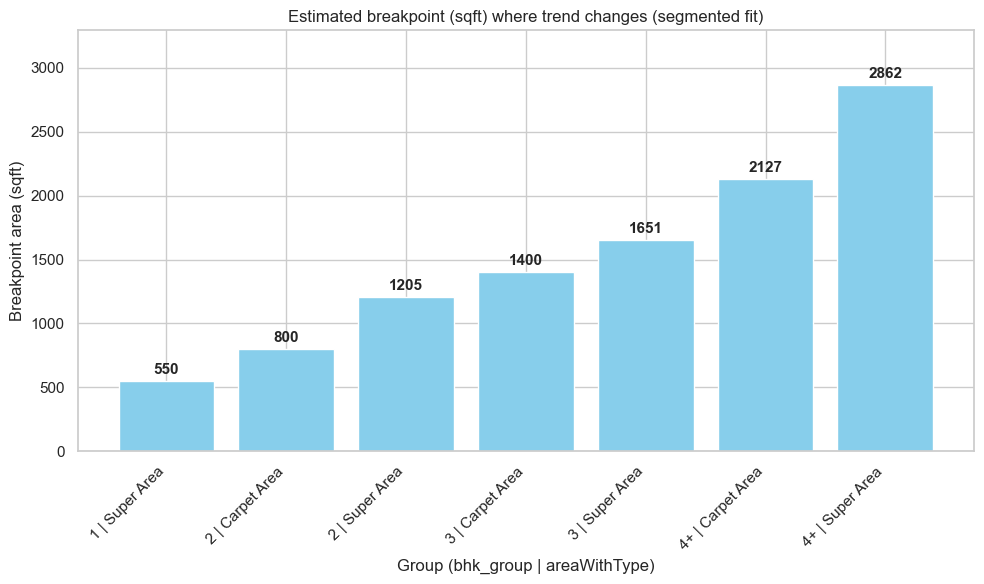

In [7]:
if not breakpoints.empty:
    plt.figure(figsize=(10, 6))

    labels = (
        breakpoints["bhk_group"].astype(str) +
        " | " +
        breakpoints["areaWithType"].astype(str)
    )

    bars = plt.bar(labels, breakpoints["breakpoint_sqft"], color='skyblue')
    plt.bar_label(bars, fmt='%.0f', padding=3, fontsize=11, fontweight='bold')
    plt.title("Estimated breakpoint (sqft) where trend changes (segmented fit)")
    plt.xlabel("Group (bhk_group | areaWithType)")
    plt.ylabel("Breakpoint area (sqft)")
    plt.xticks(rotation=45, ha="right")
    plt.ylim(top=breakpoints["breakpoint_sqft"].max() * 1.15)
    plt.tight_layout()
    plt.show()

#### C. Results & Interpretation 

**We generated three primary plots to answer the question:**

- Scatter plot (sampled): `price_per_sqft` vs `square_feet` (log scale), colored by `bhk_group`

    - Shows the overall dispersion and how different BHK groups occupy different area ranges.

- Binned median trend (**Super Area**): median `price_per_sqft` vs median `square_feet` by `bhk_group`

    - Reveals the “typical” (median) pricing trend in Super Area while reducing noise.

- Binned median trend (**Carpet Area**): same as above for Carpet Area

    - Enables comparison of trend shape and whether diminishing returns appears more clearly under this area definition.

In addition, the breakpoint table (segmented fit) provides a quantitative summary of where the trend changes.

**Direct answer to the research question**

Yes, the relationship between `square_feet` and `price_per_sqft` changes across groups, and the estimated “trend-change threshold” (breakpoint) differs by `bhk_group` and `areaWithType`.
However, clear diminishing returns (post-breakpoint decline in unit price) is mainly observed in Carpet Area for 2BHK and 3BHK, while Super Area groups mostly show non-decreasing unit prices after the breakpoint.

**Quantitative evidence** (breakpoints + slopes)

The two-segment fit estimates a breakpoint (in sqft) and the slopes before/after it (fit on log(sqft)):

|bhk_group | areaWithType | breakpoint (sqft) | slope_pre | slope_post | SSE |
|---|---|---|---|---|---|
|1	|Super Area | 550.0	| 2952.883160 | 569.594722 | 2.101150e+06|
|2	|Carpet Area | 800.0 | 4472.954234 | -482.189802 | 1.749476e+06 |
|2	|Super Area | 1205.0 | 244.662515 | 1656.141334 | 8.484192e+05 | 
|3	|Carpet Area | 1400.0 | 3355.954955 | -1567.594070 | 1.932184e+06|
|3	|Super Area | 1651.0 | -3188.798961 | 4255.431340 | 1.013498e+06 | 
|4+	|Carpet Area | 2127.0 | 2421.613382 | 115.735341 | 5.079505e+06 | 
|4+	|Super Area | 2862.5 | -4845.069494 | 2771.974644 | 3.298841e+06 | 

How to read slopes: since the model uses x = log(sqft), the slope represents the change in price_per_sqft per unit change in log-area (a scale-stabilized trend indicator).

**Interpretation by area type**

- Carpet Area shows evidence of “diminishing returns” for mid-size homes

    - 2BHK | Carpet Area

        - Breakpoint $\approx$ 800 sqft

        - slope_post = -482.19 (negative)

        - Interpretation: after ~800 sqft, the typical unit price tends to decrease as area grows → consistent with diminishing returns.

    - 3BHK | Carpet Area

        -  Breakpoint $\approx$ 1400 sqft

        - slope_post = -1567.59 (strongly negative)

        - Interpretation: diminishing returns is even more pronounced for larger 3BHK carpet-area properties.

This pattern is consistent with the Carpet Area trend plot, where some groups rise and then flatten/decline in larger-area bins.

- Super Area mostly shows non-decreasing unit prices after the breakpoint

    - 1BHK | Super Area: breakpoint $\approx$ 550 sqft, slope_post = +569.59

    - 2BHK | Super Area: breakpoint $\approx$ 1205 sqft, slope_post = +1656.14

    - 3BHK | Super Area: breakpoint $\approx$ 1651 sqft, slope_post = +4255.43

    - 4+ BHK | Super Area: breakpoint $\approx$ 2862.5 sqft, slope_post = +2771.97

After the breakpoint, Super Area listings tend to show stable or increasing median unit prices with larger size. This suggests market segmentation / premium effects (larger units may be concentrated in better projects/locations/amenities), rather than a universal “bigger $\rightarrow$ cheaper per sqft” relationship.

**Breakpoint patterns across groups** (practical takeaway)

Breakpoints increase with BHK and differ by area type:

    - 1BHK Super Area: ~550 sqft

    - 2BHK: ~800 (Carpet) vs ~1205 (Super)

    - 3BHK: ~1400 (Carpet) vs ~1651 (Super)

    - 4+ BHK: ~2127 (Carpet) vs ~2862.5 (Super)

Practical meaning: the “size threshold where pricing behavior changes” shifts upward for larger home configurations. In Carpet Area, being “oversized” relative to the typical BHK range is more likely to face unit-price discounting.

**Notable observations / surprises**

- The common expectation “bigger homes always have lower price per sqft” is not supported uniformly, especially in Super Area, where post-breakpoint slopes are positive across all groups.

- Some groups show negative slope_pre but positive slope_post (e.g., 3BHK Super Area, 4+ Super Area), indicating the relationship can reverse depending on the area regime—consistent with heterogeneous submarkets.

**Limitations**

- Two-segment fitting always returns a breakpoint even if the true relationship is smooth; therefore, conclusions rely on both slope signs and the trend plots, not breakpoint alone.

- Some bins have small n (your bin table includes bins as low as n=3–7), which can make medians jumpy and influence breakpoint placement.

- Important confounders (e.g., location, project quality, age, amenities) are not explicitly controlled here; area may proxy for these factors.

- SSE values (e.g., 4+ Carpet Area: 5.079505e+06) indicate some groups remain highly variable even after binning, suggesting additional features would be needed for cleaner trend explanation.